In [1]:
%config IPCompleter.greedy=True


In [2]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, Input, Flatten
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
from sklearn.utils import class_weight 
import matplotlib
import matplotlib.pyplot as plt

# own code
import sys
sys.path.append("..") # relative path to module toolkit
from toolkit import getLabelsFromDir

Using TensorFlow backend.


In [3]:
# setup
input_size = (224, 224, 3)
num_classes = 44
n = 50
mini_batch_size = 24 #article takes 256
epochs = 60 * 10 ** 4

model_type = 'ResNet%dv2' % (n)
save_dir = os.path.join(os.getcwd(), 'saved_models_weighted')
model_name = 'resnetOrig_%s_model.{epoch:03d}.h5' % model_type

train_dir = "../../images/images_genus/train/"
val_dir = "../../images/images_genus/val/"
train_images = 12525
val_images = 3454

save_plot_name = "resnetOrigBottleneck_weighted_trainplot.png"

In [4]:
steps_per_epoch = int(train_images/mini_batch_size) + 1
validation_steps = int(val_images/mini_batch_size) + 1

In [5]:
def resnet_layer(inputs,
                 num_filters=64,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


# Model architecture as in "Deep Residual Learning for Image Recognition"

In [6]:

def resnet_v23(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [7]:
def resnet_v2(input_shape, depth, num_classes):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    # Start model definition.
    num_filters_in = 64
    
    if depth == 50:
        residual_blockSize = [3, 4, 6, 3] # used for depth 34 and 50 layer depth models 
    else:
        raise Exception("only depth 50 is available")
    first_layer = True
    
    #init first layer
    inputs = Input(shape=input_shape)
    
    x = resnet_layer(inputs,num_filters=num_filters_in, kernel_size=7, strides=2, activation=None)
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    x = Activation('relu')(x)
    
    # Instantiate the stack of residual units
    for blockSize in residual_blockSize:
        for res_block in range(blockSize):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if first_layer:
                num_filters_out = num_filters_in * 4
                if res_block == 0: 
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out
        first_layer=False
  
    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    y = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [8]:
def resnet_v1(input_shape, depth, num_classes):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    stage 2:  8x8,  512

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes

    # Returns
        model (Model): Keras model instance
    """

    # Start model definition.
    num_filters = 64
    
    if depth == 34 or depth == 50:
        residual_blockSize = [3, 4, 6, 3] # used for depth 34 and 50 layer depth models 
    else:
        raise Exception("only depth 34 and 50 are available")
    not_first_layer = False
    
    #init first layer
    inputs = Input(shape=input_shape)
    conv = Conv2D(num_filters,
                  kernel_size=7,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    x = conv(inputs)
    x = Activation('relu')(x)
    
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    
    # Instantiate the stack of residual units
    for blockSize in residual_blockSize:
        for res_block in range(blockSize):
            strides = 1
            if not_first_layer and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if not_first_layer and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                
                # Equivalent to option B in paper, where only projection shortcuts are used for 
                # dimensionality(number of filters) increase.
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            elif not(not_first_layer):
                not_first_layer = True
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    print(x.shape)
    
    y = GlobalAveragePooling2D()(x)

    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [9]:
model = resnet_v2(input_shape=input_size, depth=n, num_classes=num_classes)

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1,momentum=0.9, decay=0.0001),
              #optimizer=SGD(lr=0.0001),
              metrics=['accuracy'])

model.summary()
print(model_type)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
activation

In [11]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown=0,
                               verbose=1,
                               patience=0,
                               min_lr=0.5e-6)

early_stop = EarlyStopping(patience=2)

callbacks = [checkpoint, lr_reducer, early_stop]

In [12]:
assert(getLabelsFromDir(train_dir) == getLabelsFromDir(val_dir))
labels = getLabelsFromDir(train_dir)

train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

#no augmentation other than rescaling pixels

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=mini_batch_size,
                                                    color_mode='rgb',
                                                    target_size=input_size[:2] )
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=mini_batch_size,
                                                    color_mode='rgb',
                                                    target_size=input_size[:2] )


Found 12263 images belonging to 44 classes.
Found 3381 images belonging to 44 classes.


In [13]:
W = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

In [14]:
# Fit the model on the batches generated by generator.
history = model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    #verbose=1,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=callbacks,
                    class_weight=W)

Epoch 1/600000
522/522 [==============================] - 354s 677ms/step - loss: 10.5057 - acc: 0.2398 - val_loss: 9.0607 - val_acc: 0.2560

Epoch 00001: val_acc improved from -inf to 0.25601, saving model to /home/herri/Documents/BachelorProject/models/resnetBottleneckOriginal/saved_models_weighted/resnetOrig_ResNet50v2_model.001.h5
Epoch 2/600000
522/522 [==============================] - 343s 656ms/step - loss: 8.5063 - acc: 0.2532 - val_loss: 7.9765 - val_acc: 0.2525

Epoch 00002: val_acc did not improve from 0.25601
Epoch 3/600000
522/522 [==============================] - 343s 657ms/step - loss: 7.5328 - acc: 0.2530 - val_loss: 7.0995 - val_acc: 0.2609

Epoch 00003: val_acc improved from 0.25601 to 0.26093, saving model to /home/herri/Documents/BachelorProject/models/resnetBottleneckOriginal/saved_models_weighted/resnetOrig_ResNet50v2_model.003.h5
Epoch 4/600000
522/522 [==============================] - 343s 658ms/step - loss: 6.7371 - acc: 0.2472 - val_loss: 6.4978 - val_acc: 

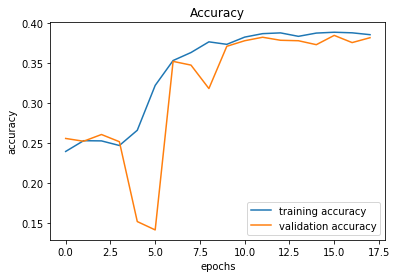

In [15]:
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(save_plot_name, bbox_inches='tight')
plt.show()